<a href="https://colab.research.google.com/github/Sjinjutha/DADS7202_DL_Hw2/blob/main/DADS7202_HW2_RetinaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#df = pd.read_csv("/content/drive/MyDrive/travel_insurance.csv")
#df.head()

Mounted at /content/drive


In [ ]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-1829761b-5efa-4859-b8f7-667f7182fe45)


In [ ]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct 20 13:00:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#pathfile  = "/content/data/coco/2017/1.1.0/coco-train.tfrecord-00000-of-00256"
#import tensorflow as tf
#import json
#from google.protobuf.json_format import MessageToJson

#dataset = tf.data.TFRecordDataset(pathfile)
#for d in dataset.take(10):
#    ex = tf.train.Example()
#    ex.ParseFromString(d.numpy())
#    m = json.loads(MessageToJson(ex))
#    #print(ex)
#    print(m['features']['feature'].keys())

# How to Building Data for Facebook-Retina

https://www.analyticsvidhya.com/blog/2020/08/how-to-build-a-face-mask-detector-using-retinanet-model/

https://towardsmachinelearning.org/face-mask-detector-using-retinanet-model/

In [ ]:
import os
print(os.getcwd())

!pip install utils

!git clone https://github.com/fizyr/keras-retinanet.git
%cd keras-retinanet/

!pip install .
!python setup.py build_ext --inplace

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6220, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 6220 (delta 5), reused 6 (delta 2), pack-reused 6205
Receiving objects: 100% (6220/6220), 13.48 MiB | 25.75 MiB/s, done.
Resolving deltas: 100% (4205/4205), done.
/content/keras-retinanet
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/keras-retinanet
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/is

In [ ]:
!pip install wget
!pip install pytz
!pip install Cython pandas tf-slim lvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=f9a9c7f66137a686b3c386c6abaa08125d6eaf951aa92b620459c94b13797c96
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 352 kB 14.4 MB/s 


In [ ]:
import numpy as np
import shutil
import pandas as pd
import os, sys, random
import re
import zipfile
import xml.etree.ElementTree as ET
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import wget
from PIL import Image # or import PIL.Image
import requests
import urllib
from keras_retinanet.utils.visualization import draw_box, draw_caption , label_color
from keras_retinanet.utils.image import preprocess_image, resize_image
from tensorflow import keras
import tensorflow_datasets as tfds

## Data processing

In [ ]:
list_name = ['Train', 'Val', 'Test']

for i in list_name:
    imagePath= f"/content/drive/MyDrive/NIDA/DADS7202/DADS7202_HW2_Data/Train_Val_Test/{i}/imagePath_{i}"
    annotPath= f"/content/drive/MyDrive/NIDA/DADS7202/DADS7202_HW2_Data/Train_Val_Test/{i}/annotPath_{i}"

    names_data = 'data_' + i
    print("names_data")

    names_data = pd.DataFrame(columns=['fileName','xmin','ymin','xmax','ymax','class'])

    os.chdir(f"/content/drive/MyDrive/NIDA/DADS7202/DADS7202_HW2_Data/Train_Val_Test/{i}/")

    #read All files
    allfiles = [f for f in listdir(annotPath) if isfile(join(annotPath, f))]
    print(f"the total quantity of annotPath in {i}:", len(allfiles))

    #Read all pdf files in images and then in text and store that in temp folder
    for file in allfiles:
        #print(file)
        if (file.split(".")[1]=='xml'):
            fileName= imagePath+'/'+file.replace(".xml",'.jpg')
            tree = ET.parse(annotPath+'/'+file)
            root = tree.getroot()
            if root.find('object') :
                for obj in root.iter('object'):
                    cls_name = obj.find('name').text
                    xml_box = obj.find('bndbox')
                    xmin = xml_box.find('xmin').text
                    ymin = xml_box.find('ymin').text
                    xmax = xml_box.find('xmax').text
                    ymax = xml_box.find('ymax').text

            # if we want 0 in all elements with unbounding box image
            #else:
            #    cls_name = ''
            #    xmin = ymin = xmax = ymax = 0

            # Append rows in Empty Dataframe by adding dictionaries
            names_data = names_data.append({'fileName': fileName, 'xmin': xmin, 'ymin':ymin,'xmax':xmax,'ymax':ymax,'class':cls_name}, ignore_index=True)
            
            # names_data.to_csv(f"all_annotation_{i}.csv", index=False)
            
    print(names_data.shape)
    print(names_data)

# os.chdir("/content/drive/MyDrive/NIDA/DADS7202/DADS7202_HW2_Data/Train_Val_Test")

names_data
the total quantity of annotPath in Train: 840
(837, 6)
                                              fileName xmin ymin xmax ymax  \
0    /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   90  202  154  250   
1    /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...  192  319  301  398   
2    /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...  192  319  301  398   
3    /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...  192  319  301  398   
4    /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...  192  319  301  398   
..                                                 ...  ...  ...  ...  ...   
832  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   14  120  127  205   
833  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   37   73  121  157   
834  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...  140  109  162  128   
835  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...  149  178  213  239   
836  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...  130  106  240  225  

In [ ]:
# We delete header column in order to implement RetinaNet in next step

annot_train_dir = "/content/drive/MyDrive/NIDA/DADS7202/DADS7202_HW2_Data/Train_Val_Test/Train/annotation_Train_GoogleColab.csv"
annot_val_dir =   "/content/drive/MyDrive/NIDA/DADS7202/DADS7202_HW2_Data/Train_Val_Test/Val/annotation_Val_GoogleColab.csv"
annot_test_dir =  "/content/drive/MyDrive/NIDA/DADS7202/DADS7202_HW2_Data/Train_Val_Test/Test/annotation_Test_GoogleColab.csv"

classes_dir = "/content/drive/MyDrive/NIDA/DADS7202/DADS7202_HW2_Data/WaterBottle_Classes.csv"

In [ ]:
columns_ = ['fileName', 'xmin', 'ymin', 'xmax', 'ymax', 'class']

train_annot = pd.read_csv(annot_train_dir, names=columns_)
train_annot.head()

fileName  xmin  ymin  xmax  ymax  \
0  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   481   761   605   910   
1  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...    15   216    94   272   
2  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   316   236   374   277   
3  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   166   245   224   300   
4  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...     2   230    74   269   

     class  
0  Crystal  
1  Crystal  
2   Nestle  
3  Crystal  
4   Nestle

In [ ]:
val_annot = pd.read_csv(annot_val_dir, names=columns_)
val_annot.head()

fileName  xmin  ymin  xmax  ymax  \
0  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...    15   250   214   438   
1  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   173   262   229   316   
2  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   264   275   302   310   
3  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...    86   224   159   275   
4  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   179   295   244   345   

      class  
0   Crystal  
1   Crystal  
2    Nestle  
3  Aquafina  
4  Aquafina

In [ ]:
test_annot = pd.read_csv(annot_test_dir, names=columns_)
test_annot.head()

fileName  xmin  ymin  xmax  ymax  \
0  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   166   106   202   180   
1  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   127   309   165   347   
2  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...    30   366    63   405   
3  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   109   343   139   376   
4  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   289   137   312   160   

     class  
0  Crystal  
1  Crystal  
2  Crystal  
3   Nestle  
4  Crystal

In [ ]:
#Define labels & write them in a file
classes = ['Nestle','Aquafina', 'Crystal']
#with open('../WaterBottle_Classes.csv', 'w') as f:
#  for i, class_name in enumerate(classes):
#    f.write(f'{class_name},{i}\n')  

In [ ]:
pd.read_csv(classes_dir, names=['class', 'index'])

class  index
0  Aquafina      0
1   Crystal      1
2    Nestle      2

                                              fileName  xmin  ymin  xmax  \
517  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...    21   218    64   
518  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   332   219   357   
519  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...    86   272   120   
520  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   213   241   230   
521  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   288   244   329   
522  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   137   216   164   
523  /content/drive/MyDrive/NIDA/DADS7202/DADS7202_...   237   254   265   

     ymax     class  
517   251  Aquafina  
518   253  Aquafina  
519   302   Crystal  
520   273   Crystal  
521   286   Crystal  
522   244    Nestle  
523   281    Nestle  
[[[187 186 181]
  [180 179 174]
  [184 183 178]
  ...
  [164 168 169]
  [162 166 167]
  [165 169 170]]

 [[187 186 181]
  [180 179 174]
  [184 183 178]
  ...
  [164 168 169]
  [162 166 167]
  [165 169 170]]

 [[187 

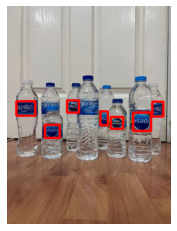

In [ ]:
# Check annotation with 1 image

data = train_annot

# pick a random image
filepath = data.sample()['fileName'].values[0]
##print(filepath)
# get all rows for this image
df2 = data[data['fileName'] == filepath]
print(df2)
im = np.array(Image.open(filepath))
print(im)

# if there's a PNG it will have alpha channel
im = im[:,:,:3]

for idx, row in df2.iterrows():
    print(idx, row)
    box = [
      row['xmin'],
      row['ymin'],
      row['xmax'],
      row['ymax'],
    ]
    print(box)
    draw_box(im, box, color=(255, 0, 0), thickness=4) #https://github.com/fizyr/keras-retinanet/blob/main/keras_retinanet/utils/visualization.py

plt.axis('off')
plt.imshow(im)
plt.show()                  
                  
#show_image_with_boxes(data)

In [ ]:
# Labelmap for each class

#labels = [{'name':'Nestle', 'id':3}, {'name':'Crystal', 'id':2}, {'name':'Aquafina', 'id':1}]

#with open('LABELMAP', 'w') as f:
#    for label in labels:
#        f.write('item { \n')
#        f.write('\tname:\'{}\'\n'.format(label['name']))
#        f.write('\tid:{}\n'.format(label['id']))
#        f.write('}\n')

# Training

In [ ]:
#os.chdir("/content/")

#os.getcwd()

In [ ]:
# Download pretrain model
## by downloading web 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'

## or 

In [ ]:
# We wil train model by 3 options

import tensorflow as tf

if os.path.exists("/content/snapshot/") == False :
        os.mkdir("snapshot")

PRETRAINED_MODEL = "/content/drive/MyDrive/NIDA/DADS7202/DADS7202_HW2_Data/Train_Val_Test/snapshots/resnet50_coco_best_v2.1.0.h5"
path_snapshot = "/content/snapshot/"

def retina_train_(steps_=100): 
    # default 1e-5  --snapshot "/content/snapshot/resnet50_csv_01.h5" \
    !python "/content/keras-retinanet/keras_retinanet/bin/train.py" \
            --backbone "resnet50" \
            --batch-size 1 \
            --epochs 30   \
            --steps {steps_}   \
            --gpu 0  \
            --weights {PRETRAINED_MODEL} \
            --tensorboard-dir './logs' \
            --snapshot-path {path_snapshot} \
            csv {annot_train_dir}  {classes_dir} \
            --val-annotations {annot_val_dir}

In [ ]:
# We wil train model by 3 options
## 1. epochs =30, steps=100

retina_train_(100)

1 Physical GPUs, 1 Logical GPUs
Creating model, this may take a second...
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9408        ['input_1[0][0]']                
                                64)                                                               
            

In [ ]:
#import tensorflow as tf

#if os.path.exists("/content/snapshot/") == False :
#    os.mkdir("snapshot")

#PRETRAINED_MODEL = "/content/drive/MyDrive/NIDA/DADS7202/DADS7202_HW2_Data/Train_Val_Test/snapshots/resnet50_coco_best_v2.1.0.h5"
#path_snapshot = "/content/snapshot/"

# default 1e-5  --snapshot "/content/snapshot/resnet50_csv_01.h5" \
#!python "/content/keras-retinanet/keras_retinanet/bin/train.py" \
#        --backbone "resnet50" \
#        --batch-size 1 \
#        --epochs 3   \
#        --steps 100   \
#        --gpu 0  \
#        --snapshot "/content/snapshot/resnet50_csv_271.h5" \
#        --tensorboard-dir './logs' \
#        --snapshot-path {path_snapshot} \
#        csv {annot_train_dir}  {classes_dir} \
#        --val-annotations {annot_val_dir}

1 Physical GPUs, 1 Logical GPUs
Loading model, this may take a second...
Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9408        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, None, None,   256         ['conv1[0][0]']                  
                 

In [ ]:
## 2. epochs =30, steps=500

retina_train_(steps_=500)

Streaming output truncated to the last 5000 lines.
  annotations['bboxes'][invalid_indices, :]
351/500 [====================>.........] - ETA: 49s - loss: 1.3284 - regression_loss: 0.8732 - classification_loss: 0.4552/content/keras-retinanet/keras_retinanet/bin/../../keras_retinanet/preprocessing/generator.py:181: UserWarning: Image /content/drive/MyDrive/NIDA/DADS7202/DADS7202_HW2_Data/Train_Val_Test/Train/imagePath_Train/218.jpg with id 182 (shape (500, 375, 3)) contains the following invalid boxes: [[ 838. 1192.  898. 1246.]].
  annotations['bboxes'][invalid_indices, :]
357/500 [====================>.........] - ETA: 47s - loss: 1.3456 - regression_loss: 0.8826 - classification_loss: 0.4629/content/keras-retinanet/keras_retinanet/bin/../../keras_retinanet/preprocessing/generator.py:181: UserWarning: Image /content/drive/MyDrive/NIDA/DADS7202/DADS7202_HW2_Data/Train_Val_Test/Train/imagePath_Train/244.jpg with id 158 (shape (500, 375, 3)) contains the following invalid boxes: [[417. 8

In [ ]:
#@title Default title text
#for i in range(2,31):
#    print("epochs: ",i)
#    !python "/content/keras-retinanet/keras_retinanet/bin/train.py" \
#                --backbone "resnet50" \
#                --batch-size 1 \
#                --epochs 1   \
#                --steps 1000   \
#                --gpu 0  \
#                --snapshot "/content/snapshot/resnet50_csv_01.h5" \
#                --tensorboard-dir './logs' \
#                --snapshot-path {path_snapshot} \
#                csv {annot_train_dir}  {classes_dir} \
#                --val-annotations {annot_val_dir}

Streaming output truncated to the last 5000 lines.
 n)                             256)                                                              
                                                                                                  
 res4b_branch2c (Conv2D)        (None, None, None,   262144      ['res4b_branch2b_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 bn4b_branch2c (BatchNormalizat  (None, None, None,   4096       ['res4b_branch2c[0][0]']         
 ion)                           1024)                                                             
                                                                                                  
 res4b (Add)                    (None, None, None,   0           ['bn4b_branch2c[0][0]',          
                                1024)                     

In [ ]:
## 3. epochs =30, steps=1000

retina_train_(steps_=1000)

1 Physical GPUs, 1 Logical GPUs
Creating model, this may take a second...
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9408        ['input_1[0][0]']                
                                64)                                                               
            

In [ ]:
#!python "/content/keras-retinanet/keras_retinanet/bin/train.py" \
#        --backbone "resnet50" \
#        --batch-size 1 \
#        --epochs 30   \
#        --steps 1000   \
#        --gpu 0  \
#        --weights {PRETRAINED_MODEL} \
#        --tensorboard-dir './logs' \
#        --snapshot-path {path_snapshot} \
#        csv {annot_train_dir}  {classes_dir} \
#        --val-annotations {annot_val_dir}

In [ ]:
#import os
#import glob

#files = glob.glob('/content/snapshot/*')
#for f in files:
#    if f != "/content/snapshot/resnet50_csv_271.h5":
#        os.remove(f)

In [ ]:
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession

#def fix_gpu():
#    config = ConfigProto()
#    config.gpu_options.allow_growth = True
#    session = InteractiveSession(config=config)

#fix_gpu()

In [ ]:
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

model_path = os.path.join(path_snapshot, sorted(os.listdir(path_snapshot), reverse=True)[0])
print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')  ## Use backbone as resnet50
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pd.read_csv(classes_dir,header=None).T.loc[0].to_dict()
labels_to_names

/content/snapshot/resnet50_csv_01.h5


{0: 'Aquafina', 1: 'Crystal', 2: 'Nestle'}

In [ ]:
THRES_SCOREs = 0.35  # Set Score Threshold Value

import cv2
import time

def df_plot_orinal(drawOG, img_path, df):
    df = df[df['fileName']==img_path]
    for i,r in df.iterrows():
        cv2.rectangle(drawOG, (r['xmin'], r['ymin']), (r['xmax'], r['ymax']), (255,0,0),2)
    

def img_inference(img_path, df_data, THRES_SCORE=THRES_SCOREs):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    drawOG = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    df_plot_orinal(drawOG, img_path, df_data)
    # correct for image scale
    boxes /= scale
    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        #print(score)
        if score < THRES_SCORE:
            continue
        color = label_color(label)
        b = box.astype(int)
        draw_box(draw, b, color=color)
        caption = "{} {:.3f}%".format(labels_to_names[label], score*100)
        print(box, score, label)
        
    fig = plt.figure(figsize=(20, 20))
    ax1=fig.add_subplot(1, 2, 1)
    plt.imshow(draw)
    ax2=fig.add_subplot(1, 2, 2)
    plt.imshow(drawOG)

    ax1.title.set_text('Predicted')
    ax2.title.set_text('Actual')
    plt.show()

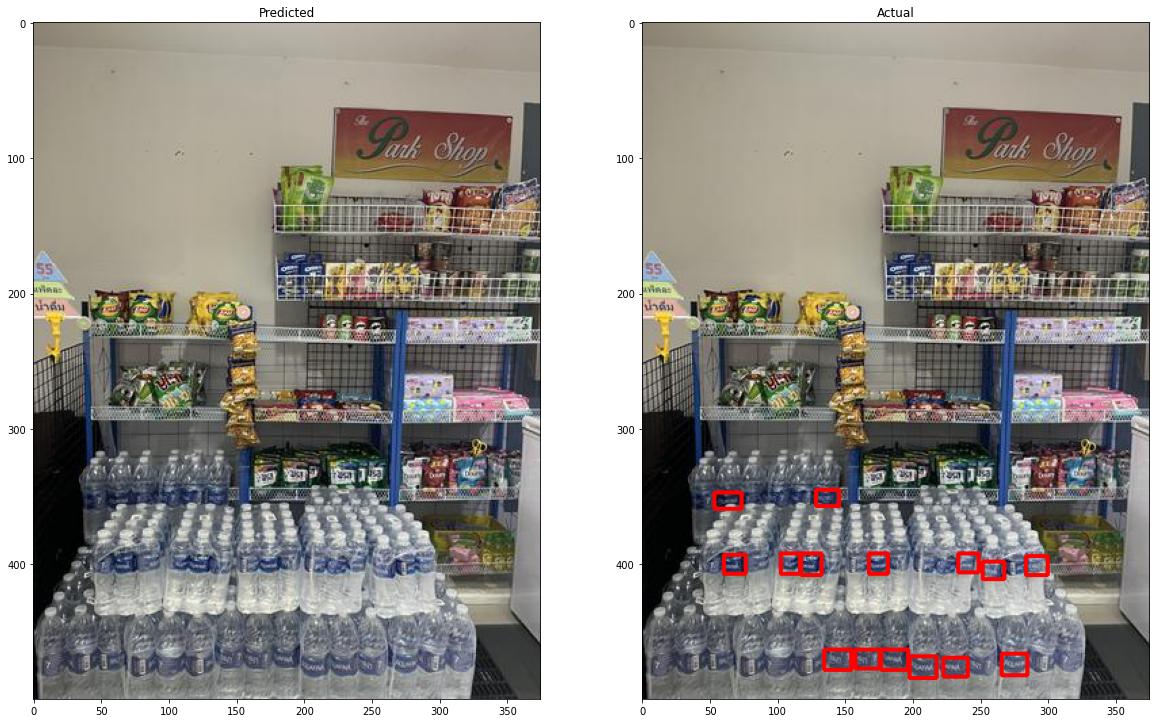

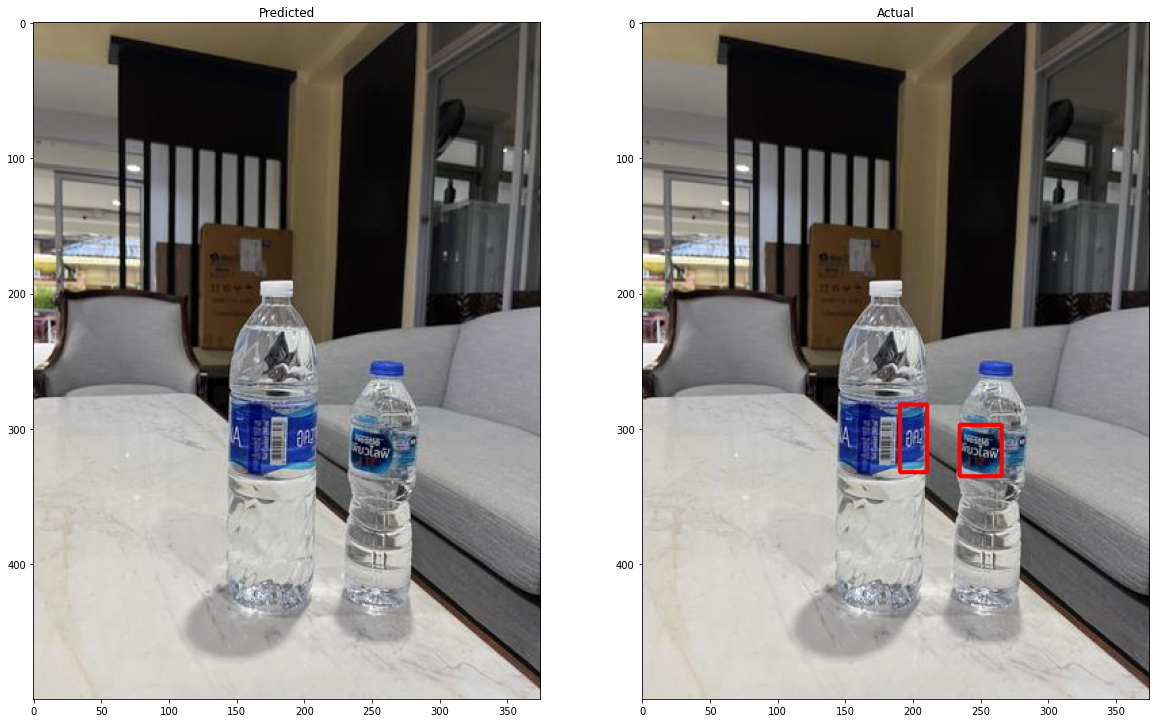

[228.05116 225.95044 330.9546  346.62015] 0.9999962 1
[ 11.472758  19.871912 170.58133  169.53041 ] 0.99958354 2


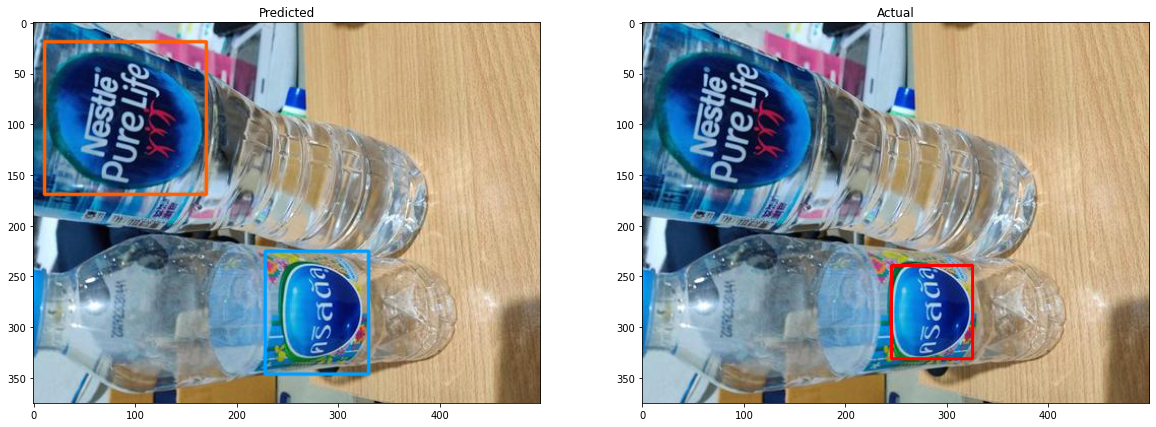

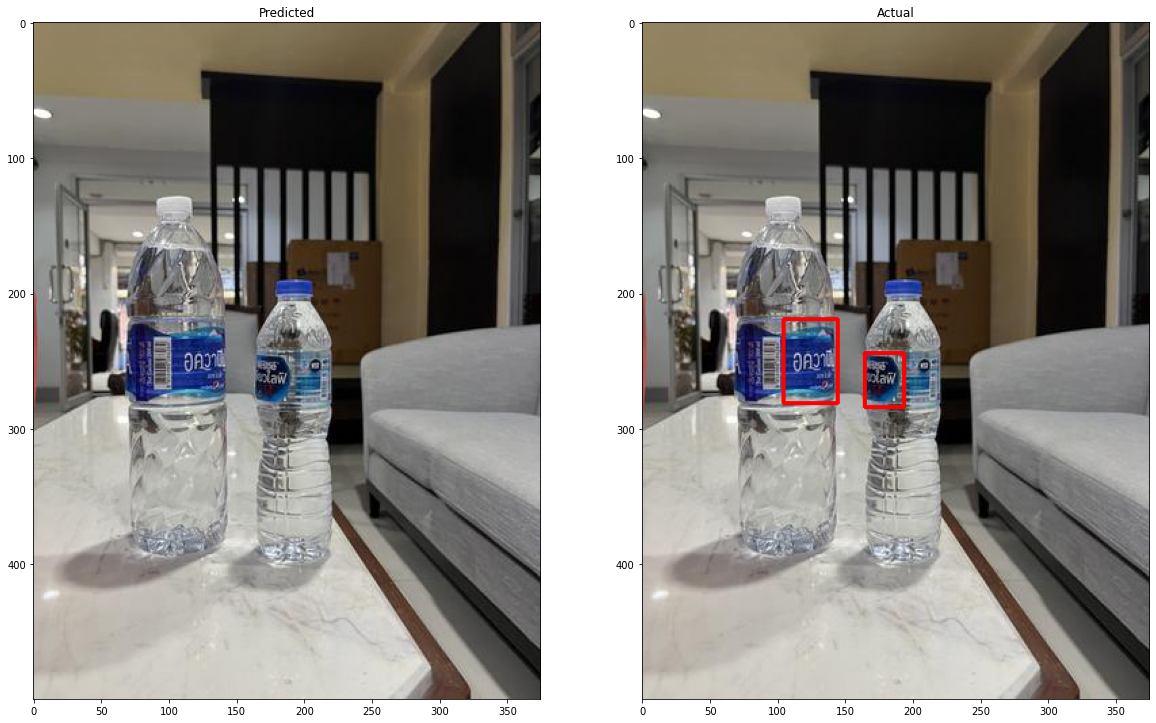

[391.86398 269.9265  499.68747 374.5056 ] 0.98988986 2


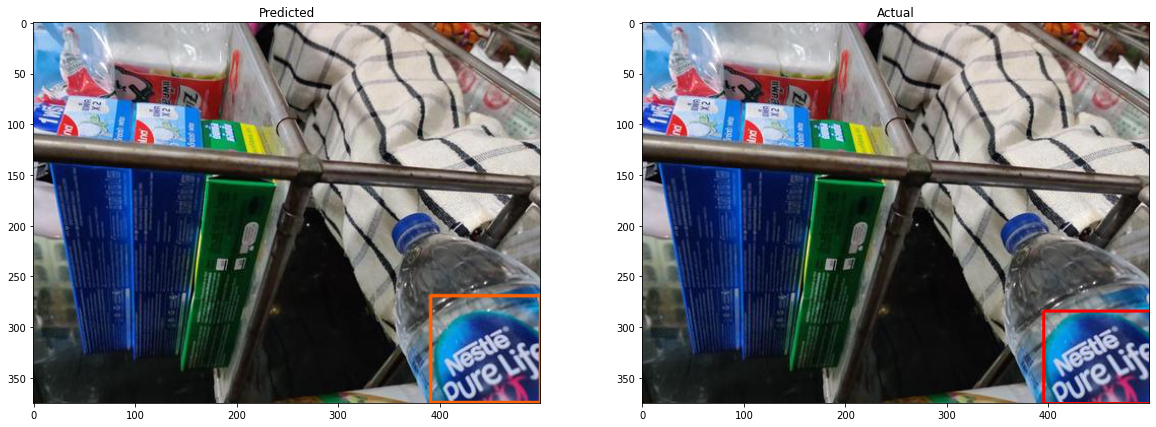

In [ ]:
# Predict in random image

THRES_SCORE_Adjust = 0.4

#print(test_annot.head())

data_sample = test_annot.sample(n=5)  #Predict on Random 5 Image
for i,r in data_sample.iterrows():
    img_inference(r['fileName'], test_annot, THRES_SCORE_Adjust)

In [ ]:
# Evaluation with test_data

import tensorflow as tf

for i in range(1,4):
    model_path_r = f"/content/drive/MyDrive/NIDA/DADS7202/DADS7202_HW2_Data/Snapshot/round{i}_best_resnet50.h5"

    !python "/content/keras-retinanet/keras_retinanet/bin/evaluate.py" \
        csv {annot_test_dir} {classes_dir} \
        {model_path_r} --convert-model

# pd.DataFrame(evaluate_result)

Loading model, this may take a second...
2022-10-20 14:24:29.877632: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Running network: 100% (112 of 112) |######| Elapsed Time: 0:00:19 Time:  0:00:19
Parsing annotations: 100% (112 of 112) |##| Elapsed Time: 0:00:00 Time:  0:00:00
61 instances of class Aquafina with average precision: 0.0692
46 instances of class Crystal with average precision: 0.1887
70 instances of class Nestle with average precision: 0.1372
Inference time for 112 images: 0.1393
mAP using the weighted average of precisions among classes: 0.1272
mAP: 0.1317
Loading model, this may take a second...
2022-10-20 14:25:24.099560: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Running network: 100% (1